<a href="https://colab.research.google.com/github/MaiSerry/DoctBot_grad/blob/main/Copy_of_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install datasets

In [ ]:
!pip install -U transformers

# Imports Tools

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import TFAutoModelForSequenceClassification , AutoTokenizer,BertTokenizer,BertForSequenceClassification,Trainer,TrainingArguments
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
from datasets import Dataset
from tqdm import tqdm

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# load Dataset

In [ ]:
df=pd.read_csv('/content/symptomsDisease246k.csv')
df.head()

,query,response
0,"anxiety and nervousness ,shortness of breath ,...",panic disorder
1,"shortness of breath ,depressive or psychotic s...",panic disorder
2,"anxiety and nervousness ,depression ,shortness...",panic disorder
3,"anxiety and nervousness ,depressive or psychot...",panic disorder
4,"anxiety and nervousness ,depression ,insomnia ...",panic disorder


In [ ]:
df.shape

(246945, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246945 entries, 0 to 246944
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   query     246945 non-null  object
 1   response  246945 non-null  object
dtypes: object(2)
memory usage: 3.8+ MB


In [ ]:
df.duplicated().sum()

np.int64(57298)

In [ ]:
df.drop_duplicates(inplace=True)
df.shape

(189647, 2)

In [ ]:
df.head()

,query,response
0,"anxiety and nervousness ,shortness of breath ,...",panic disorder
1,"shortness of breath ,depressive or psychotic s...",panic disorder
2,"anxiety and nervousness ,depression ,shortness...",panic disorder
3,"anxiety and nervousness ,depressive or psychot...",panic disorder
4,"anxiety and nervousness ,depression ,insomnia ...",panic disorder


In [ ]:
df.tail()

,query,response
246937,"diminished hearing ,headache",open wound of the nose
246938,"diminished hearing ,headache ,facial pain ,nos...",open wound of the nose
246941,"diminished hearing ,nosebleed",open wound of the nose
246943,"diminished hearing ,headache ,nosebleed",open wound of the nose
246944,"diminished hearing ,facial pain",open wound of the nose


In [ ]:
print("Number of Diseases ",len(set(df['response'])))

Number of Diseases  773


In [ ]:
diseases=pd.DataFrame(set(df['response']))
diseases.head()


,0
0,rotator cuff injury
1,decubitus ulcer
2,hydronephrosis
3,hematoma
4,drug abuse


In [ ]:
diseases.to_csv('diseases.csv',index=False)

<ipython-input-16-497ba5242637>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_diseases.values, y=top_diseases.index, palette="viridis")


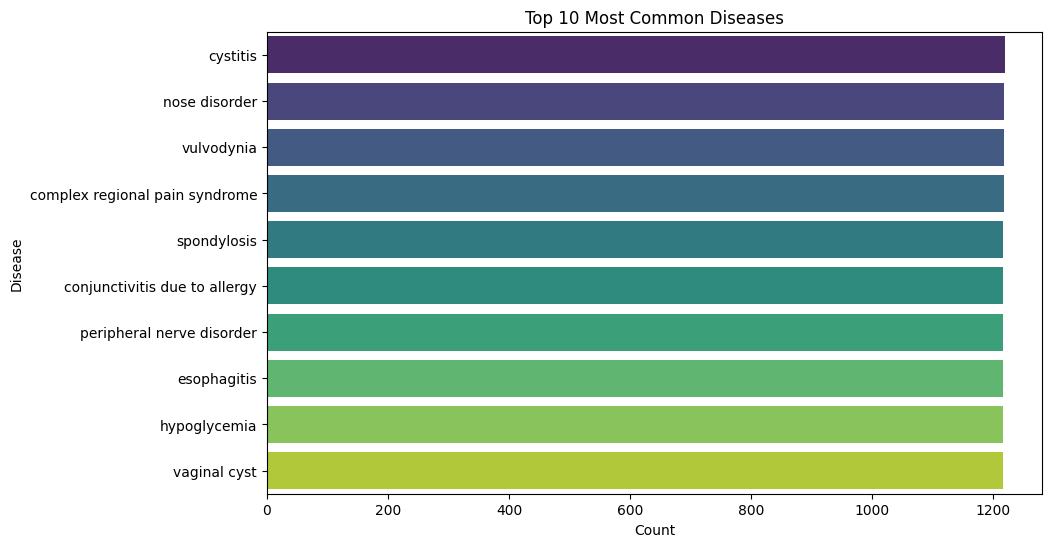

In [ ]:
top_diseases = df['response'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_diseases.values, y=top_diseases.index, palette="viridis")
plt.title("Top 10 Most Common Diseases")
plt.xlabel("Count")
plt.ylabel("Disease")
plt.show()

<ipython-input-17-a4785bd49303>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Count", y="Symptom", data=symptom_df, palette="mako")


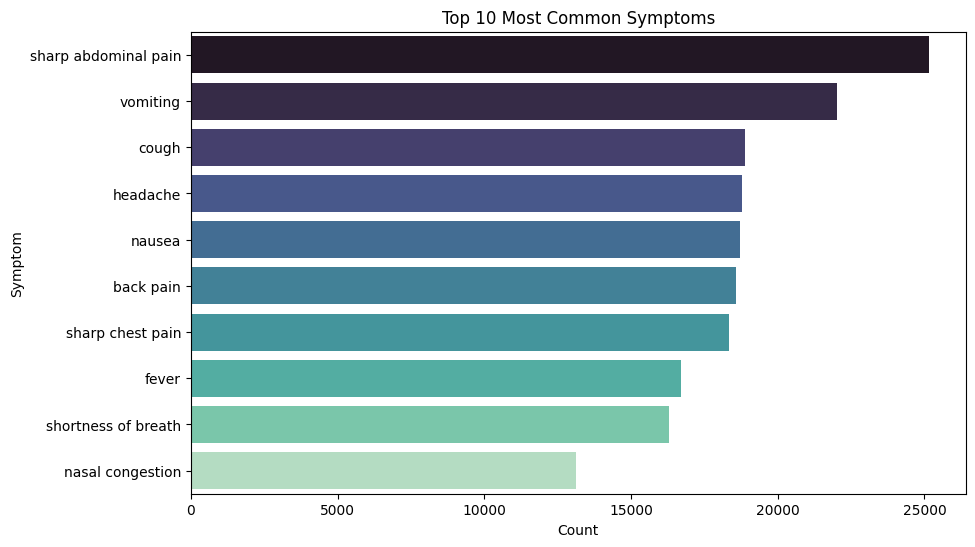

In [ ]:
from collections import Counter

all_symptoms = df['query'].dropna().str.lower().str.split(',')
flat_symptoms = [sym.strip() for sublist in all_symptoms for sym in sublist]
symptom_counts = Counter(flat_symptoms)
top_symptoms = symptom_counts.most_common(10)


symptom_df = pd.DataFrame(top_symptoms, columns=["Symptom", "Count"])

plt.figure(figsize=(10, 6))
sns.barplot(x="Count", y="Symptom", data=symptom_df, palette="mako")
plt.title("Top 10 Most Common Symptoms")
plt.xlabel("Count")
plt.ylabel("Symptom")
plt.show()

100%|██████████| 189647/189647 [00:00<00:00, 718865.10it/s]


Text(0.5, 1.0, 'Distribution of symptoms length')

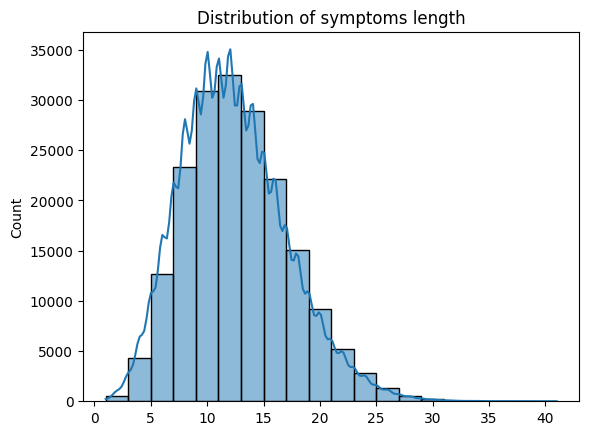

In [ ]:
length = []
for txt in tqdm(df['query'].values):
    length.append(len(txt.split()))

sns.histplot(length, kde = True, bins = 20)
plt.title('Distribution of symptoms length')

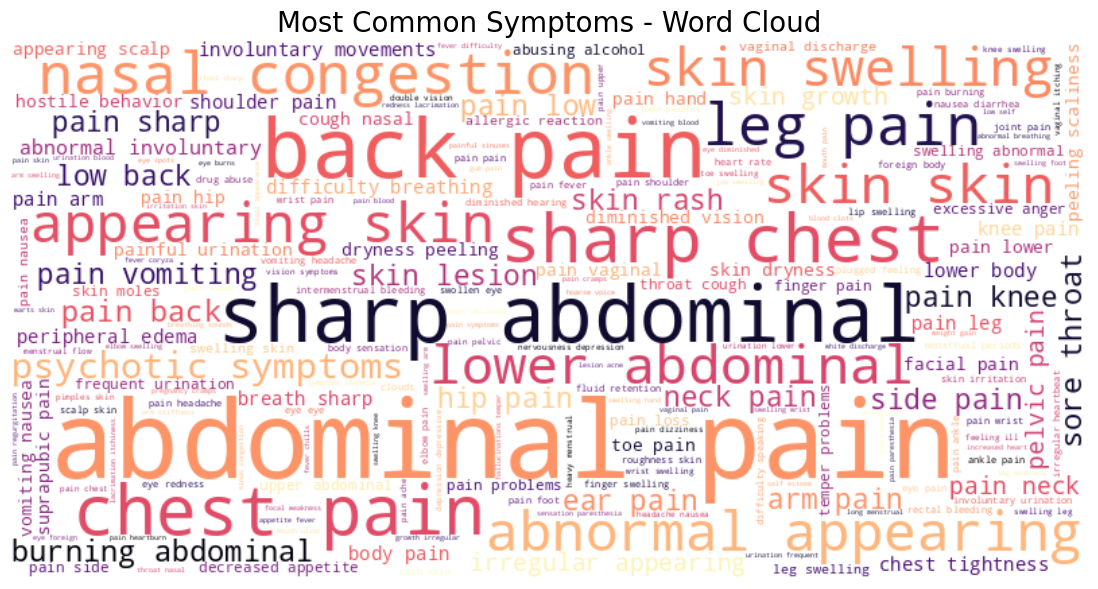

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


symptom_text = ' '.join(
    [sym.strip().lower() for sublist in df['query'].dropna().str.split(',') for sym in sublist]
)


wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(symptom_text)


plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Symptoms - Word Cloud", fontsize=20)
plt.show()

# preprocessing


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))

def clean_steatment(text):
  text=text.lower()

  text=re.sub(r"[^a-zA-Z]\s","",text)
  #tokenizer
  words=text.split()
  words=[word for word in words if word not in stop_words ]

  return ' '.join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
clean_steatment('diminished hearing ,headache ,facial pain') ## its important "," to model undersatnd the symptoms

'diminished hearing ,headache ,facial pain'

In [ ]:
df['query']=df['query'].apply(clean_steatment)
df['query'].head()

,query
0,"anxiety nervousness ,shortness breath ,depress..."
1,"shortness breath ,depressive psychotic symptom..."
2,"anxiety nervousness ,depression ,shortness bre..."
3,"anxiety nervousness ,depressive psychotic symp..."
4,"anxiety nervousness ,depression ,insomnia ,abn..."


In [ ]:
df['response'].value_counts()

,count
response,
cystitis,1219
nose disorder,1218
vulvodynia,1218
complex regional pain syndrome,1217
spondylosis,1216
...,...
kaposi sarcoma,1
open wound of the jaw,1
scurvy,1


## balance dataset

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler(sampling_strategy='auto',random_state=42)

X=df.drop(columns=['response'])
y=df['response']
# perform oversampling
X_resampled,y_resampled= ros.fit_resample(X,y)
df=pd.concat([X_resampled,y_resampled],axis=1)
df['response'].value_counts()

,count
response,
open wound of the nose,1219
panic disorder,1219
vocal cord polyp,1219
turner syndrome,1219
cryptorchidism,1219
...,...
eye alignment disorder,1219
headache after lumbar puncture,1219
pyloric stenosis,1219


# Labeling

In [ ]:
labal_encoder=LabelEncoder()
df['label']=labal_encoder.fit_transform(df['response'])
df.head()

,query,response,label
0,"anxiety nervousness ,shortness breath ,depress...",panic disorder,531
1,"shortness breath ,depressive psychotic symptom...",panic disorder,531
2,"anxiety nervousness ,depression ,shortness bre...",panic disorder,531
3,"anxiety nervousness ,depressive psychotic symp...",panic disorder,531
4,"anxiety nervousness ,depression ,insomnia ,abn...",panic disorder,531


# Spliting

In [ ]:
train_texts,test_texts,train_labels,test_labels=train_test_split(df['query'],df["label"],test_size=0.2,random_state=42)

# Tokenization

In [ ]:
tokenizer= BertTokenizer.from_pretrained("bert-base-uncased")
df['num_tokens'] = df['query'].apply(lambda x: len(tokenizer.tokenize(x)))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
print("Numebr of tokens ",df['num_tokens'].count())

Numebr of tokens  942287


In [ ]:
df.head()

,query,response,label,num_tokens
0,"anxiety nervousness ,shortness breath ,depress...",panic disorder,531,26
1,"shortness breath ,depressive psychotic symptom...",panic disorder,531,19
2,"anxiety nervousness ,depression ,shortness bre...",panic disorder,531,31
3,"anxiety nervousness ,depressive psychotic symp...",panic disorder,531,22
4,"anxiety nervousness ,depression ,insomnia ,abn...",panic disorder,531,17


In [ ]:
df['num_tokens'].describe()

,num_tokens
count,942287.000000
mean,13.188737
std,6.802571
min,1.000000
25%,8.000000
50%,12.000000
75%,17.000000
max,64.000000


In [ ]:
print("Numebr of unique tokens ",len(set(df['query'])))

Numebr of unique tokens  169888


In [ ]:
max([len(st) for st in df['query']])

252

In [ ]:
train_encoder=tokenizer(train_texts.tolist(),truncation=True,padding=True,max_length=270)
test_encoder=tokenizer(test_texts.tolist(),truncation=True,padding=True,max_length=270)

In [ ]:
#convert to dataset fromat
#train_dataset=tf.data.Dataset.from_tensor_slices((dict(train_encoder),train_labels.tolist()))
#test_dataset=tf.data.Dataset.from_tensor_slices((dict(test_encoder),test_labels.tolist()))

In [ ]:
train_dataset=Dataset.from_dict({'input_ids':train_encoder['input_ids'],'attention_mask':train_encoder['attention_mask'],'labels':train_labels.to_list()})
test_dataset=Dataset.from_dict({'input_ids':test_encoder['input_ids'],'attention_mask':test_encoder['attention_mask'],'labels':test_labels.to_list()})

# Model

In [ ]:
model=BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=len(labal_encoder.classes_))

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import transformers
print(transformers.__version__)
print(transformers.__file__)

4.51.3
/usr/local/lib/python3.11/dist-packages/transformers/__init__.py


In [ ]:
from transformers import TrainingArguments
print("eval_strategy" in dir(TrainingArguments))

True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_path = "/content/drive/MyDrive/bert_outputs"
!mkdir -p {output_path}

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=output_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir=f"{output_path}/logs",
    logging_steps=50,
    lr_scheduler_type="linear",
    gradient_accumulation_steps=2,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True

)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [ ]:
from transformers import Trainer


trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: maiserry100 (maiserry100-eduction) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.385400,0.342186
2,0.250000,0.265866


TrainOutput(global_step=70671, training_loss=0.6171699963565175, metrics={'train_runtime': 11748.215, 'train_samples_per_second': 192.496, 'train_steps_per_second': 6.015, 'total_flos': 7.723069806637232e+16, 'train_loss': 0.6171699963565175, 'epoch': 2.9998938766847076})

# Model Evaluation

In [ ]:
# Predictions
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Classification Report
print(classification_report(test_labels, predicted_labels, target_names=labal_encoder.classes_))

# Confusion Matrix

#cm = confusion_matrix(test_labels, predicted_labels)
#plt.figure(figsize=(10, 7))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labal_encoder.classes_, yticklabels=labal_encoder.classes_)
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.title('Confusion Matrix')
#plt.show()

                                                          precision    recall  f1-score   support

                               abdominal aortic aneurysm       0.94      0.96      0.95       218
                                        abdominal hernia       0.98      0.98      0.98       233
                                         abscess of nose       0.87      0.95      0.91       237
                                     abscess of the lung       1.00      1.00      1.00       250
                                  abscess of the pharynx       0.86      0.90      0.88       267
                                    acanthosis nigricans       0.82      1.00      0.90       277
                                               acariasis       0.91      0.89      0.90       253
                                               achalasia       0.82      0.91      0.86       239
                                                    acne       0.70      0.89      0.78       250
                   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# save and upload

In [ ]:
trainer.save_model("/content/drive/MyDrive/DoctorBot_symptoms_disease")
tokenizer.save_pretrained("/content/drive/MyDrive/DoctorBot_symptoms_disease")

('/content/drive/MyDrive/DoctorBot_symptoms_disease/tokenizer_config.json',
 '/content/drive/MyDrive/DoctorBot_symptoms_disease/special_tokens_map.json',
 '/content/drive/MyDrive/DoctorBot_symptoms_disease/vocab.txt',
 '/content/drive/MyDrive/DoctorBot_symptoms_disease/added_tokens.json')

In [ ]:
import joblib
joblib.dump(labal_encoder, '/content/drive/MyDrive/label_encoder.pkl')

['/content/drive/MyDrive/label_encoder.pkl']

In [ ]:
! pip install huggingface_hup --p


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

ambiguous option: --p (--platform, --pre, --prefer-binary, --prefix, --progress-bar, --proxy, --pypi-url, --python, --python-version?)


In [ ]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
The token `DoctorBot` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when

In [ ]:
## the free hardware resource is closed

NameError: name 'trainer' is not defined

RAM: 12.67 GB


✅ GPU Available: Tesla T4
